<div style="background-color: RGB(0, 124, 176);" >
<h2 style="margin: auto; padding: 20px; color:#fff;text-align: center ">PROJET 12  - DETECTER DES FAUX BILLETS - APPLICATION ML 
</h2>
</div>


**Objectifs**
Lorsqu’un billet arrive, nous avons une machine qui consigne l’ensemble
de ses caractéristiques géométriques. Au fil de nos années de lutte, nous
avons observé des différences de dimensions entre les vrais et les faux
billets. Ces différences sont difficilement visibles à l’œil nu, mais une
machine devrait sans problème arriver à les différencier.
Ainsi, il faudrait construire un algorithme qui, à partir des caractéristiques
géométriques d’un billet, serait capable de définir si ce dernier est un vrai
ou un faux billet.

**=> Mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.**

**SOMMAIRE:**

[Etape 1. Importation des librairies et chargement du fichier préparé](#Etape-1.-Importation-des-librairies-et-chargement-du-fichier-préparé)

[Etape 2. Mise en des algorithmes](#Etape-2.-Mise-en-des-algorithmes)

[Etape 3. Test des nouveaux billets avec le modèle choisi](#Etape-3.-Test-des-nouveaux-billets-avec-le-modèle-choisi)

[Etape 4. Automatisation des prédictions via l'application](#Etape-4.-Automatisation-des-prédictions-via-l'application)



<div style="background-color: RGB(0, 124, 176);" >
<h2 style="margin: auto; padding: 20px; color:#fff;text-align: center ">Etape 1. Importation des librairies et chargement du fichier préparé</h2>
</div>

#### 1.1 Importation des librairies

In [410]:
#Importations des librairies de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Importations de la librairies sklearn pour les modèles de prédiction
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#Importations des librairies pour l'analyse factorielle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Importation des indicateurs de performance 
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#### 1.2 Chargement du fichier

In [411]:
df = pd.read_csv("df.csv")

In [412]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<div style="background-color: RGB(0,124,176);" >
<h2 style="margin: auto; padding: 20px; color:#fff;text-align: center ">Etape 2. Mise en des algorithmes </h2>
</div>

## 2.1 Méthode d'apprentissage non supervisé

### 2.1.1 ACP (réduction des dimensions)

In [413]:
#Séparation des Variables explicatives (X) et cible (y)
X = df.drop("is_genuine", axis=1)
y = df["is_genuine"]

In [414]:
#Normaliser les données 

# Créer un objet scaler de la classe StandardScaler
scaler = StandardScaler()

# Utiliser la méthode fit_transform() sur l'objet scaler pour normaliser les données
X_scaled = scaler.fit_transform(X)

In [415]:
#Réduction de dimensions
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [416]:
#Choix du nombre de dimensions pour l'ACP

#Calcul du pourcentage variance expliquée pour chaque dimension

n_components = len(pca.explained_variance_) #Nombre de dimensions

comp = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(n_components)], 
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)
comp

,Dimension,Valeur propre,% variance expliquée,% cum. var. expliquée
0,Dim1,2.594234,43.0,43.0
1,Dim2,1.018090,17.0,60.0
2,Dim3,0.781720,13.0,73.0
3,Dim4,0.709964,12.0,85.0
4,Dim5,0.580229,10.0,95.0
5,Dim6,0.319765,5.0,100.0


Les 2 premiers axes expliquent 60% de la variance.

Text(0.5, 0.98, 'Variance expliquée par dimension')

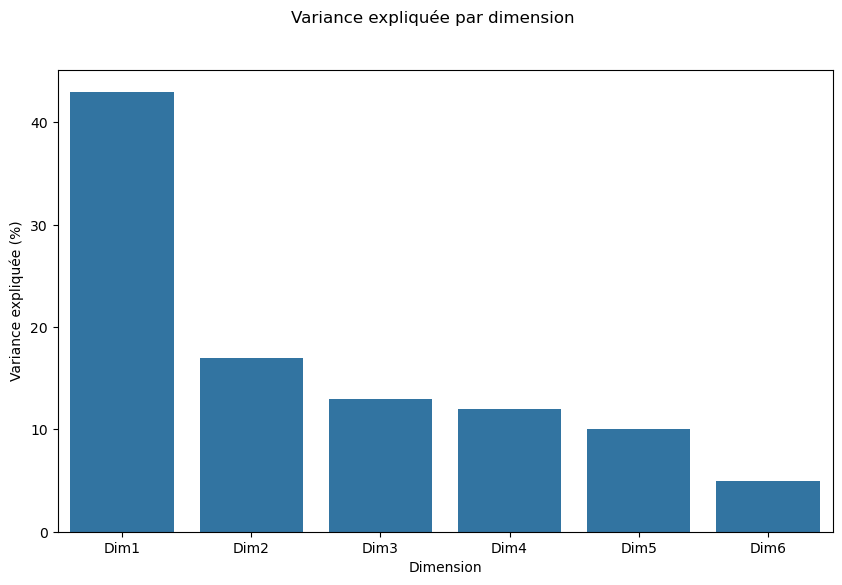

In [417]:
# Scree plot pour choisir le nombre de composantes principales

plt.figure(figsize=(10,6))
g_comp = sns.barplot(x = "Dimension", 
                y = "% variance expliquée",
                
                data = comp)
g_comp.set(ylabel = "Variance expliquée (%)")
g_comp.figure.suptitle("Variance expliquée par dimension")


In [418]:
# Contribution à la formation de l'axe
# Obtenir les composantes principales

# loadings = coordonnées des variables dans l'espace factoriel
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Calcul des cos² : (coordonnées²) / (longueur totale²)
cos2 = (loadings ** 2) / np.sum(loadings ** 2, axis=1)[:, np.newaxis]

# Mettre dans un DataFrame
cos2_df = pd.DataFrame(
    cos2,
    index=df.columns[1:],
    columns=[f"PC{i+1}" for i in range(cos2.shape[1])]
)

# Ajouter une colonne avec la qualité de représentation cumulée sur PC1+PC2
cos2_df["Qualité (PC1+PC2)"] = cos2_df["PC1"] + cos2_df["PC2"]

print("Tableau des cos² (qualité de représentation des variables)")
display(cos2_df.round(3))


Tableau des cos² (qualité de représentation des variables)


,PC1,PC2,PC3,PC4,PC5,PC6,Qualité (PC1+PC2)
diagonal,0.019,0.902,0.064,0.007,0.008,0.000,0.920
height_left,0.285,0.096,0.612,0.002,0.006,0.000,0.381
height_right,0.402,0.012,0.021,0.533,0.032,0.000,0.414
margin_low,0.665,0.005,0.009,0.006,0.189,0.125,0.671
margin_up,0.500,0.000,0.057,0.139,0.293,0.010,0.500
length,0.722,0.002,0.018,0.022,0.053,0.184,0.724


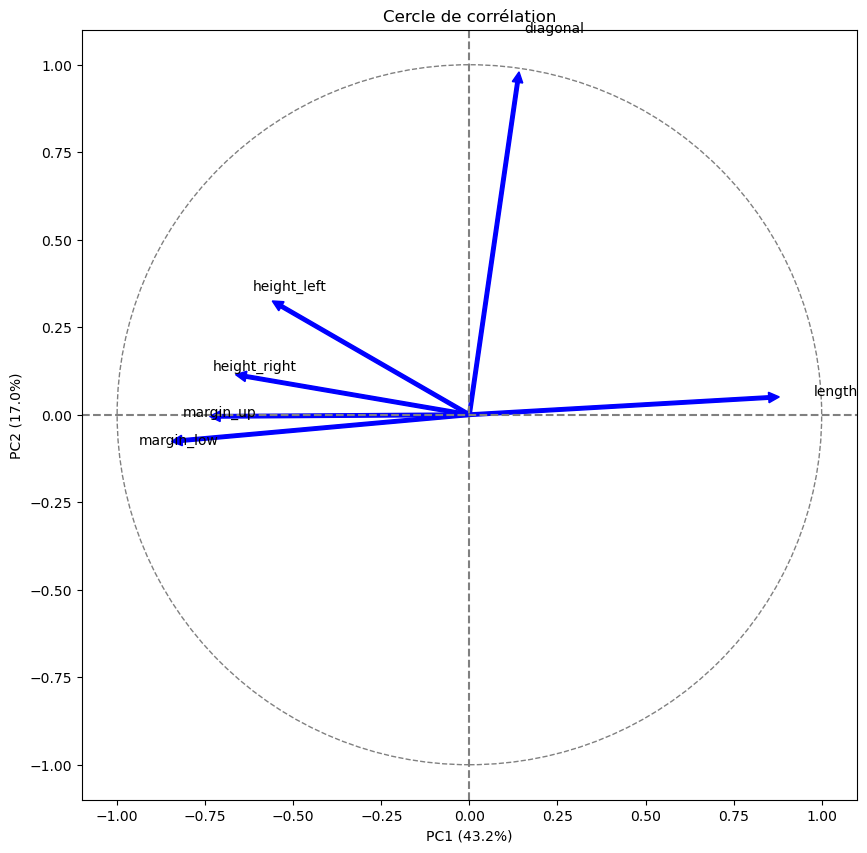

In [419]:
#  Cercle de corrélation
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.figure(figsize=(10,10))
circle = plt.Circle((0,0), 1, fill=False, linestyle="--", color="gray")
plt.gca().add_patch(circle)
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")

for i, var in enumerate(X.columns):
    plt.arrow(0,0,loadings[i,0],loadings[i,1], head_width=0.03,width=0.01, head_length=0.03, fc="blue", ec="blue")
    plt.text(loadings[i,0]*1.15, loadings[i,1]*1.15, var, fontsize=10)


plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Cercle de corrélation")
plt.show()

* L'axe factoriel 1 synthétise les billets qui sont longs, ayant des grandes marges aux bords (du haut et du bas) et qui ont une grande hauteur sur le bord haut.

* L'axe factoriel 2 synthétise les billets ayant une grande diagonale.

* Les variables des marges et des hauteurs sont très corrélées

### 2.1.2 Clustering K-means 

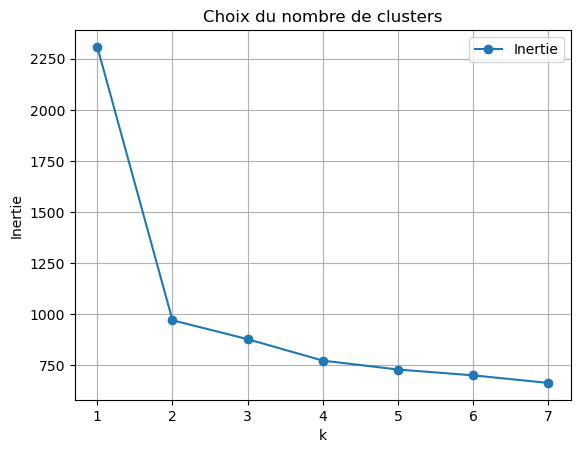

In [420]:
#Choisir le nombre de clusters

inertias = []  #somme des distances au carré entre chaque valeur et le centroïde d'un cluster 

for k in range(1,8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)

#Visualisation
plt.plot(range(1,8), inertias, "-o", label="Inertie")
plt.xlabel("k")
plt.ylabel("Inertie")
plt.title("Choix du nombre de clusters")
plt.grid()
plt.legend()
plt.show()

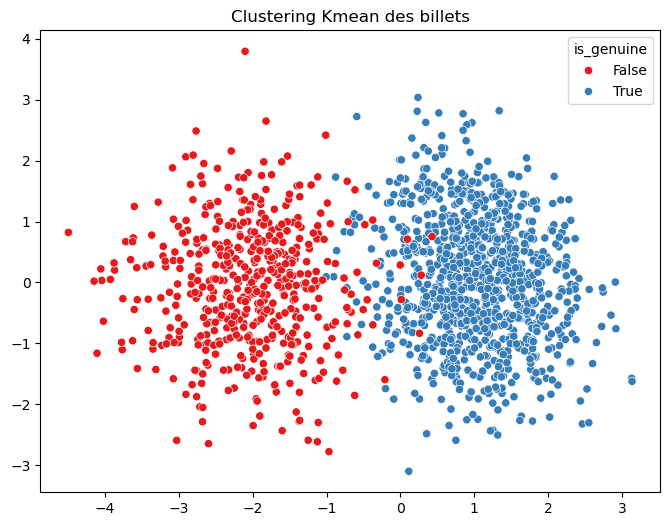

In [421]:
# Visualisation du clustering

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["is_genuine"], palette="Set1")

plt.title("Clustering Kmean des billets")
plt.show()

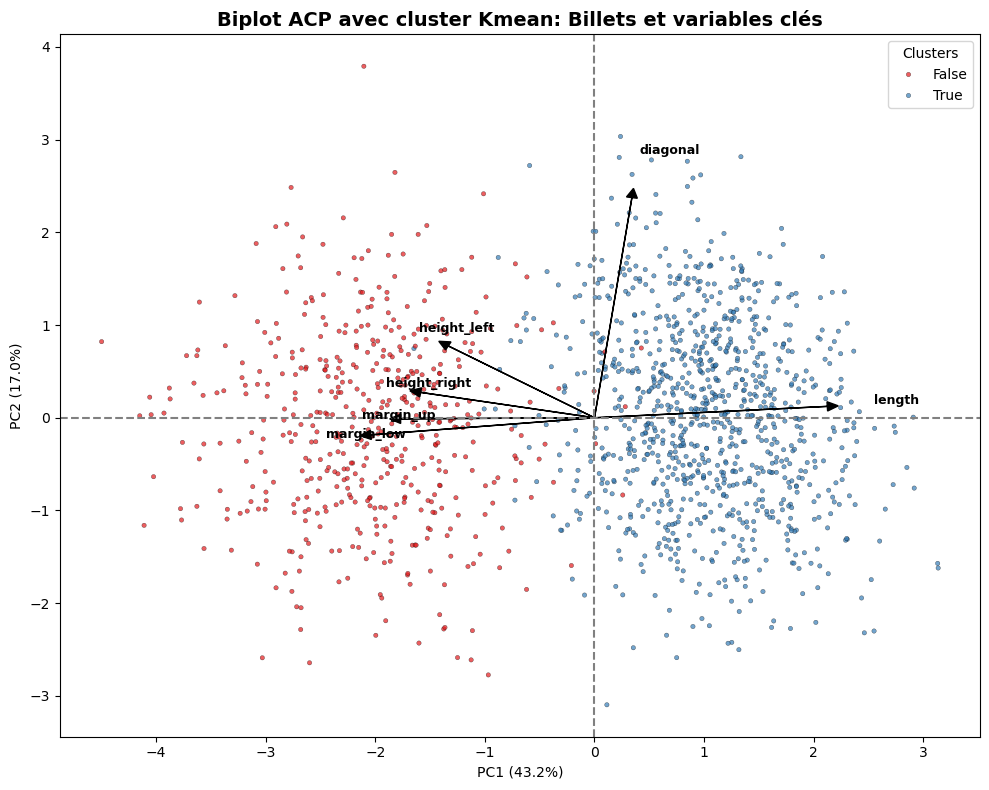

In [422]:
#  Biplot ACP AVEC CLUSTER DE BILLETS

# Vecteurs des variables normalisés pour cercle de corrélation
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

#Dimension du graphique
plt.figure(figsize=(10, 8))


# Nuage de points pour représenter les billets
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue= df["is_genuine"], 
                palette="Set1", s=10, alpha=0.7, edgecolor="k")

#Nommer chaque billet par sa nature (True/False)
#for i, billet in enumerate(df["is_genuine"]):
    #plt.text(X_pca[i,0]+0.1, X_pca[i,1], billet, fontsize=7, alpha=0.7)

# Vecteurs des variables
for i, var in enumerate(X.columns):
    plt.arrow(0, 0, loadings[i,0]*2.5, loadings[i,1]*2.5, 
              head_width=0.1, head_length=0.1, fc="black", ec="black")
    plt.text(loadings[i,0]*3, loadings[i,1]*3, var, color="black", fontsize=9,fontweight="black")


# Axes et titres
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Biplot ACP avec cluster Kmean: Billets et variables clés", fontsize=14, fontweight="bold")
plt.legend(title="Clusters", loc="best")
plt.tight_layout()
plt.show()

In [423]:
#Séparation des variables prédictives (X) et variable cible (y)
X = df.drop(columns="is_genuine")
y= df["is_genuine"]

In [424]:
#Division en jeu d’entraînement et test : On garde 80 % pour l’apprentissage et 20 % pour le test.

X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.2, random_state=42) #Random_state pour obtenir toujours le même découpage


In [425]:
#Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [426]:
# Création et Entraînement du modèle
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

#Prédictions des clusters sur le jeu de données test
y_pred_kmeans = kmeans.predict(X_test)

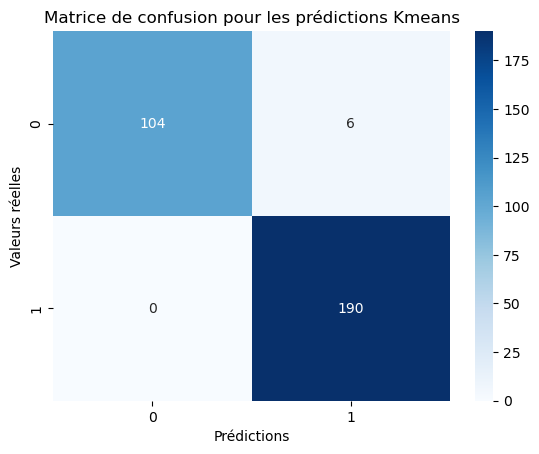

In [427]:
#Visualisation de la matrice de confusion
cm_kmeans = confusion_matrix(y_test,y_pred_kmeans)
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Valeurs réelles")
plt.xlabel("Prédictions")
plt.title("Matrice de confusion pour les prédictions Kmeans")
plt.show()

Le modèle K-means prédit 6 faux billets comme de vrais billets.

In [428]:
#Performance du modèle K-means
print("\nPerformance du K-means:\n", classification_report(y_test,y_pred_kmeans))


Performance du K-means:
               precision    recall  f1-score   support

       False       1.00      0.95      0.97       110
        True       0.97      1.00      0.98       190

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



Le modèle ne détecte pas bien les faux billets (recall 95%).

## 2.2 Méthode d'apprentissage supervisé

### 2.2.1 K-nearest neighbors (KNN)

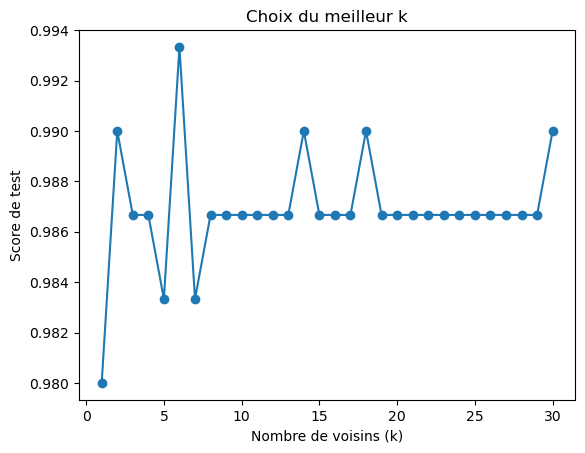

In [429]:
#Choix du meilleur nombre de voisins
scores = []
for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.plot(range(1, 31), scores, marker='o')
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Score de test")
plt.title("Choix du meilleur k")
plt.show()

Le meilleur nombre de voisins se trouvent entre 20 et 30 voisins.

In [430]:
#Créer et entraîner le modèle
knn= KNeighborsClassifier(n_neighbors=25) #On regarde les 25 voisins les plus proches pour décider la classe.
knn.fit(X_train_scaled , y_train)

#Faire les prédictions
y_pred_knn = knn.predict(X_test_scaled)

#Afficher les performances du modèle
print("\nRésultat du K-nearest_neighbors:\n", classification_report(y_test,y_pred_knn))


Résultat du K-nearest_neighbors:
               precision    recall  f1-score   support

       False       1.00      0.96      0.98       110
        True       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



* La performance du Knn montre que tous les faux billets n'ont pas été détectés (recall à 96%)
* Et il y a de vrais billets qui n'ont pas été détéctés comme vrais billets (precision 98%)

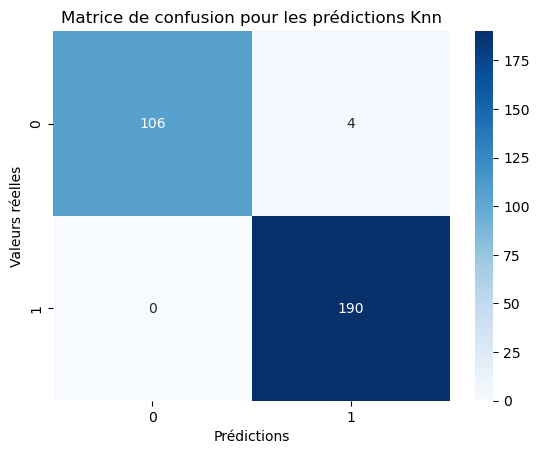

In [431]:
#Visualisation de la matrice de confusion
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion pour les prédictions Knn")
plt.show()

0 représente les faux billets et les 1 représente les vrais billets

**Cette matrice des prédictions faite par le K-nearest-neighbors dit que**:

--> **Il y a 4 faux billets qui ont été reconnus comme vrais** 

### 2.2.2 Régression logistique

In [432]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

print("\nRésultat de la Régression logistique:\n", classification_report(y_test, y_pred_lr)) 


Résultat de la Régression logistique:
               precision    recall  f1-score   support

       False       1.00      0.98      0.99       110
        True       0.99      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



* La performance est légèrement mieux que le Knn car il a plus détectés de vrais billets comme vrais
* Il a détecté plus de faux billets que Knn.

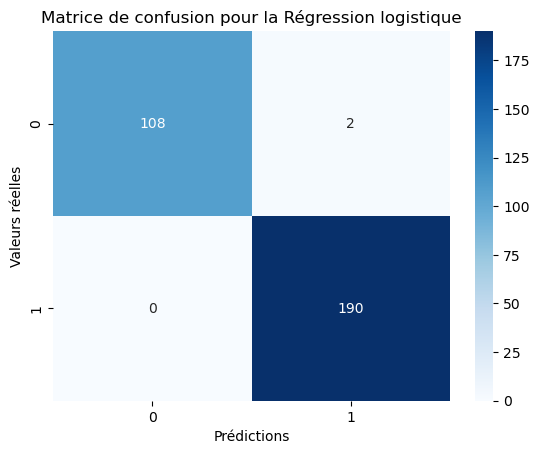

In [433]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion pour la Régression logistique")
plt.show()

0 représentent les faux billets et les 1 représentent les vrais billets

Cette **matrice des prédictions faite par la Régression logistique indique que**:

--> Il y a 108 faux billets qui ont été reconnus comme faux et aucuns faux billets qui ont été reconnus comme vrai

--> **Il y a 2 faux billets qui ont été reconnus comme vrais** et 190 vrais billets qui ont été reconnus comme vrais

### 2.2.3 Random forest

In [434]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRésultat du Random forest :\n", classification_report(y_test, y_pred_rf))


Résultat du Random forest :
               precision    recall  f1-score   support

       False       1.00      0.97      0.99       110
        True       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



* La performance du Random forest est légèrement moins bonne que la régression logistique car le recall est à 97% (faux billets non détectés) et la precision à 98% pour les vrais billets reconnus comme vrais

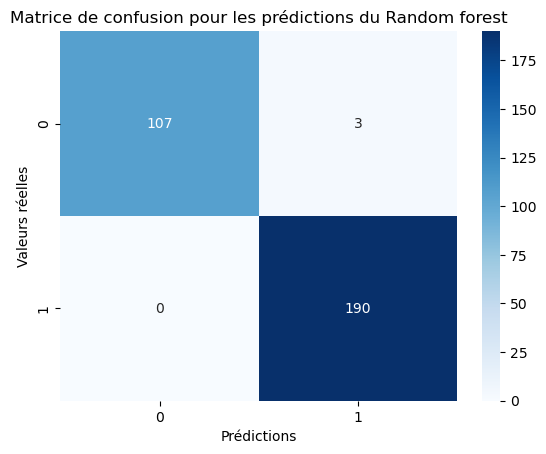

In [435]:
#Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion pour les prédictions du Random forest")
plt.show()

0 représentent les faux billets et les 1 représentent les vrais billets

Cette **matrice des prédictions faite par le Random Forest indique que**:

--> Il y a 107 faux billets qui ont été reconnus comme faux et aucuns faux billets qui ont été reconnus comme vrai

--> **Il y a 3 faux billets qui ont été reconnus comme vrais** et 190 vrais billets qui ont été reconnus comme vrais

In [436]:
#Résumer les résultats des 4 algorithmes dans un tableau de score
models = {
    "kmeans": (y_test, y_pred_kmeans),
    "knn": (y_test, y_pred_knn),
    "regression_logistique": (y_test, y_pred_lr),
    "random_forest": (y_test, y_pred_rf)
}

metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1-score": f1_score
}

# Calcul des scores par modèle et par métrique
results = {}
for model_name, (y_true, y_pred) in models.items():
    results[model_name] = {}
    for metric_name, metric_func in metrics.items():
        if metric_name == "Precision" or metric_name == "Recall" or metric_name == "F1-score":
            # Si multiclass, spécifier average='weighted' ou 'macro' selon contexte
            score = metric_func(y_true, y_pred, average='weighted')
        else:
            score = metric_func(y_true, y_pred)
        results[model_name][metric_name] = score

# Transformer en DataFrame
tab_perf = pd.DataFrame(results).T  # Transposé pour avoir modèles en lignes, métriques en colonnes

print(tab_perf)



                       Accuracy  Precision    Recall  F1-score
kmeans                 0.980000   0.980612  0.980000  0.979875
knn                    0.986667   0.986942  0.986667  0.986613
regression_logistique  0.993333   0.993403  0.993333  0.993320
random_forest          0.990000   0.990155  0.990000  0.989970


Je vais choisir le modèle de régression logistique car la performance globale est la meilleure (plus précis) et la matrice de confusion démontre qu'il fait moins d'erreurs de prédiction sur les faux billets comparée aux 3 autres modèles.

<div style="background-color: RGB(0,124,176);" >
<h2 style="margin: auto; padding: 20px; color:#fff;text-align: center ">Etape 3. Test des nouveaux billets avec le modèle choisi </h2>
</div>

In [437]:
# Charger le nouveau fichier
billets = pd.read_csv("billets_production.csv")

In [438]:
print(billets.head())

   diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5


In [439]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
 6   id            5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 412.0+ bytes


#### 3.1 Prédiction avec Régression logistique sur les nouveaux billets

In [440]:
#Suppression de la variable "id" pour ne garder que  variables prédictives (dimensions du billet)
X_new = billets.drop(columns="id")

#Normalisation
X_new_scaled = scaler.transform(X_new)

#Prédictions sur les nouveaux billets
y_pred_rf_new = log_reg.predict(X_new_scaled )



#Création d'une colonne "Prédiction" sur le dataset "billets" pour enregistrer les résultats des prédictions pour chaque billet.
billets["Prédiction"] = y_pred_rf_new

#Afficher les résultats
billets

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prédiction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


#### 3.2 Probabilité des prédictions

In [441]:
# Probabilités de chaque classe
proba_rf_new = rf.predict_proba(X_new)

# Ajouter la probabilité d'être un vrai billet / faux billet
billets["Proba_vrai"] = proba_rf_new[:, 1]  # colonne 1 = proba(True)
billets["Proba_faux"] = proba_rf_new[:, 0]

billets[["id", "Prédiction", "Proba_faux", "Proba_vrai"]]


,id,Prédiction,Proba_faux,Proba_vrai
0,A_1,False,1.00,0.00
1,A_2,False,1.00,0.00
2,A_3,False,1.00,0.00
3,A_4,True,0.02,0.98
4,A_5,True,0.00,1.00


Parmi les 5 nouveaux billets, il y aurait 3 faux billets selon le modèle de régression logistique.
Leur probabilité qu'il soit bien faux est de 100% pour chaque billet.

<div style="background-color: RGB(0,124,176);" >
<h2 style="margin: auto; padding: 20px; color:#fff;text-align: center ">Etape 4. Automatisation des prédictions via l'application </h2>
</div>

#### 4.1 Sauvegarde de l'algorithme retenu dans un pickle

In [442]:
# Sauvegarde du modèle et du scaler

import pickle

# --- Enregistrer le modèle de régression logistique ---
with open("modele_regression_logistique.pkl", "wb") as f:
    pickle.dump(log_reg, f)

#### 4.1 Création de la fonction d'automatisation des détections de faux billets

In [443]:
#Création de la fonction qui charge le modèle et le scaler sauvegardés,puis prédit si les nouveaux billets sont vrais ou faux.

import pandas as pd
import pickle

def predire_billets(fichier_csv):
   
    # Charger le modèlE
    with open("modele_regression_logistique.pkl", "rb") as f_model:
        modele = pickle.load(f_model)
    
    # Charger les nouvelles données
    billet = pd.read_csv(fichier_csv)
    
    # Sélectionner les colonnes utilisées pour l'entraînement
    colonnes = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
    X_nouveau = billet[colonnes]
    
    # Appliquer la même normalisation
    X_nouveau_scaled = scaler.transform(X_nouveau)
    
    # Faire les prédictions
    y_pred = modele.predict(X_nouveau_scaled)

    # Créer les probabilités
    proba = modele.predict_proba(X_nouveau_scaled)
    
    # Ajouter les résultats dans le DataFrame
    billet['prediction'] = y_pred
    billet['probabilité'] = proba.max(axis=1)
    
    # Sauvegarder les résultats dans un fichier CSV
    billet.to_csv("resultats_prediction_billets.csv", index=False)
    
    print("Prédictions terminées. Fichier enregistré sous 'resultats_prediction_billets.csv'")
    return billet


In [444]:
resultats = predire_billets("billets_production.csv")
resultats

Prédictions terminées. Fichier enregistré sous 'resultats_prediction_billets.csv'


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction,probabilité
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,0.997899
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,0.999742
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,0.999576
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,0.969377
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,0.999813
